## **3-1: 이진 입력 RBM을 MNIST 데이터에 적용**

**버전오류문제로 아래 코드 수정** </br>

Epoch: 0001
Epoch: 0002
Epoch: 0003
Epoch: 0004
Epoch: 0005
Epoch: 0006
Epoch: 0007
Epoch: 0008
Epoch: 0009
Epoch: 0010
RBM 학습 완료 !


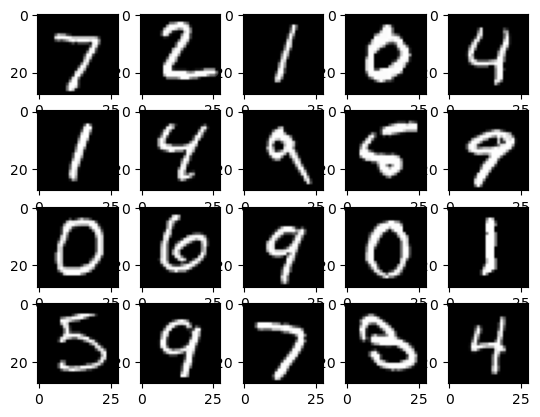

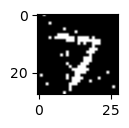

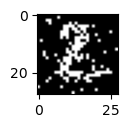

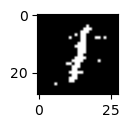

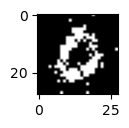

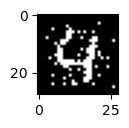

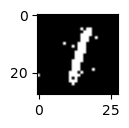

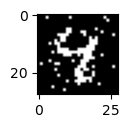

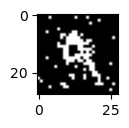

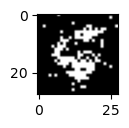

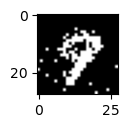

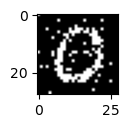

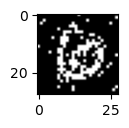

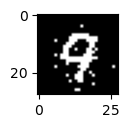

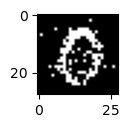

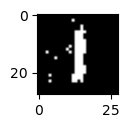

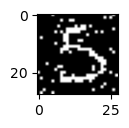

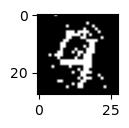

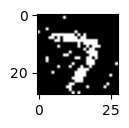

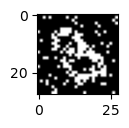

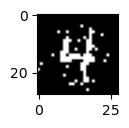

In [28]:
import numpy as np
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

# MNIST 데이터셋 로드
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 전처리
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# 학습 관련 매개변수 설정
n_input = 784
n_hidden = 500
display_step = 1
num_epochs = 10
batch_size = 256
lr = tf.constant(0.001, tf.float32)

# 입력, 가중치 및 편향 정의
x = tf.placeholder(tf.float32, [None, n_input], name="x")
W = tf.Variable(tf.random_normal([n_input, n_hidden], 0.01), name="W")
b_h = tf.Variable(tf.zeros([1, n_hidden], tf.float32, name="b_h"))
b_i = tf.Variable(tf.zeros([1, n_input], tf.float32, name="b_i"))


# 확률을 이산 상태 (0 또는 1)로 변환하는 함수 정의
def binary(probs):
    return tf.floor(probs + tf.random.uniform(tf.shape(probs), 0, 1))


# Gibbs 표본추출 단계
def cd_step(x_k):
    h_k = binary(tf.sigmoid(tf.matmul(x_k, W) + b_h))
    x_k = binary(tf.sigmoid(tf.matmul(h_k, tf.transpose(W)) + b_i))
    return x_k


# 표본추출 단계 실행
def cd_gibbs(k, x_k):
    for i in range(k):
        x_out = cd_step(x_k)
    return x_out


# CD-2 알고리즘
x_s = cd_gibbs(2, x)
act_h_s = tf.sigmoid(tf.matmul(x_s, W) + b_h)

act_h = tf.sigmoid(tf.matmul(x, W) + b_h)
_x = binary(tf.sigmoid(tf.matmul(act_h, tf.transpose(W)) + b_i))

# 가중치 및 편향 업데이트
W_add = tf.multiply(lr / batch_size, tf.subtract(tf.matmul(tf.transpose(x), act_h), \
                                                 tf.matmul(tf.transpose(x_s), act_h_s)))
bi_add = tf.multiply(lr / batch_size, tf.reduce_sum(tf.subtract(x, x_s), 0, True))
bh_add = tf.multiply(lr / batch_size, tf.reduce_sum(tf.subtract(act_h, act_h_s), 0, True))
updt = [W.assign_add(W_add), b_i.assign_add(bi_add), b_h.assign_add(bh_add)]

# 텐서플로 그래프 실행
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    total_batch = len(x_train) // batch_size
    for epoch in range(num_epochs):
        for i in range(total_batch):
            batch_xs = x_train[i * batch_size:(i + 1) * batch_size]
            _ = sess.run([updt], feed_dict={x: batch_xs})

        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1))

    print("RBM 학습 완료 !")

    out = sess.run(act_h, feed_dict={x: x_test[:20]})

    plt.figure(1)
    for k in range(20):
        plt.subplot(4, 5, k + 1)
        image = x_test[k].reshape(28, 28)
        plt.imshow(image, cmap='gray')

    plt.figure(2)
    for k in range(20):
        plt.subplot(4, 5, k + 1)
        image = sess.run(_x, feed_dict={act_h: np.reshape(out[k], (-1, n_hidden))})
        image = np.reshape(image, (28, 28))
        plt.imshow(image, cmap='gray')

        plt.show()  # 그래프 표시

    sess.close()